In [36]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam

In [41]:
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 8
EPOCHS = 5

In [2]:
covid_df_orig = pd.read_pickle('./covid_df.pkl')
covid_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 126
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patientid       76 non-null     int64  
 1   offset          56 non-null     float64
 2   sex             67 non-null     object 
 3   age             63 non-null     float64
 4   finding         76 non-null     object 
 5   survival        29 non-null     object 
 6   view            76 non-null     object 
 7   date            76 non-null     object 
 8   location        60 non-null     object 
 9   filename        76 non-null     object 
 10  doi             44 non-null     object 
 11   url            76 non-null     object 
 12  license         14 non-null     object 
 13  clinical notes  71 non-null     object 
 14  other notes     32 non-null     object 
 15  Unnamed: 15     0 non-null      float64
dtypes: float64(3), int64(1), object(12)
memory usage: 10.1+ KB


In [3]:
covid_df, covid_df_val, d1, d2 = train_test_split(covid_df_orig, covid_df_orig, test_size=0.1, random_state=42)
covid_df.shape, covid_df_val.shape

((68, 16), (8, 16))

In [4]:
rsna_df_orig = pd.read_pickle('./rsna_df.pkl')
rsna_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20672 entries, 0 to 30224
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  20672 non-null  object 
 1   x          0 non-null      float64
 2   y          0 non-null      float64
 3   width      0 non-null      float64
 4   height     0 non-null      float64
 5   Target     20672 non-null  int64  
 6   filename   20672 non-null  object 
 7   is_covid   20672 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ MB


In [5]:
rsna_df, rsna_df_val, d1, d2 = train_test_split(rsna_df_orig, rsna_df_orig, test_size=0.1, random_state=42)
rsna_df.shape, rsna_df_val.shape

((18604, 8), (2068, 8))

In [6]:
class Covid19SiameseDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
        self.imageFolder = root_dir
        self.transform = transform
        
    def __getitem__(self, index):
        get_same_class = random.randint(0,1)
        label = None
        img_0 = None
        img_1 = None
        if(get_same_class):
            label = 1
            if(random.randint(0,1)):
                img_0 = rsna_df.filename.sample(1).values[0]
                img_1 = rsna_df.filename.sample(1).values[0]
            else:
                img_0 = covid_df.filename.sample(1).values[0]
                img_1 = covid_df.filename.sample(1).values[0]
        else:
            label = 0
            if(random.randint(0,1)):
                img_0 = covid_df.filename.sample(1).values[0]
                img_1 = rsna_df.filename.sample(1).values[0]
            else:
                img_0 = rsna_df.filename.sample(1).values[0]
                img_1 = covid_df.filename.sample(1).values[0]
        
        img_0 = Image.open(self.imageFolder+img_0)
        img_1 = Image.open(self.imageFolder+img_1)
        img_0 = img_0.convert("L")
        img_1 = img_1.convert("L")
        
        if(self.transform is not None):
            img_0 = self.transform(img_0)
            img_1 = self.transform(img_1)
        
        return img_0, img_1, torch.from_numpy(np.array(label))
    
    def __len__(self):
        return len(os.listdir(self.imageFolder))

In [14]:
class Covid19SiameseDataSet_val(Dataset):
    def __init__(self, root_dir, transform=transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                                               transforms.ToTensor()
                                                              ])):
        self.imageFolder = root_dir
        self.transform = transform
        
    def __getitem__(self, index):
        get_same_class = random.randint(0,1)
        label = None
        img_0 = None
        img_1 = None
        if(get_same_class):
            label = 1
            if(random.randint(0,1)):
                img_0 = rsna_df_val.filename.sample(1).values[0]
                img_1 = rsna_df_val.filename.sample(1).values[0]
            else:
                img_0 = covid_df_val.filename.sample(1).values[0]
                img_1 = covid_df_val.filename.sample(1).values[0]
        else:
            label = 0
            if(random.randint(0,1)):
                img_0 = covid_df_val.filename.sample(1).values[0]
                img_1 = rsna_df_val.filename.sample(1).values[0]
            else:
                img_0 = rsna_df_val.filename.sample(1).values[0]
                img_1 = covid_df_val.filename.sample(1).values[0]
        
        img_0 = Image.open(self.imageFolder+img_0)
        img_1 = Image.open(self.imageFolder+img_1)
        img_0 = img_0.convert("L")
        img_1 = img_1.convert("L")
        
        if(self.transform is not None):
            img_0 = self.transform(img_0)
            img_1 = self.transform(img_1)
        
        return img_0, img_1, torch.from_numpy(np.array(label))
    
    def __len__(self):
        return len(os.listdir(self.imageFolder))

In [15]:
covid_dataset = Covid19SiameseDataSet('./images/', 
                                      transform=transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                                    transforms.RandomAffine(degrees=20, 
                                                                                            translate=[0.1, 0.1], 
                                                                                            scale=[0.95,1.2]),
                                                                    transforms.ToTensor()
                                                                   ]))

covid_dataset_val = Covid19SiameseDataSet_val('./images/')

[0 0 0 0 1 1 0 0]


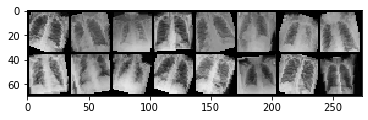

In [27]:
vis_dataloader = DataLoader(covid_dataset,
                            shuffle=True,
                            batch_size=BATCH_SIZE)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.imshow(torchvision.utils.make_grid(concatenated).permute(1, 2, 0))
print(example_batch[2].numpy())

[1 0 0 1 0 0 0 0]


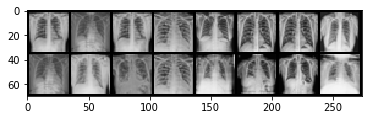

In [33]:
vis_dataloader_val = DataLoader(covid_dataset_val,
                                shuffle=False,
                                batch_size=BATCH_SIZE)
dataiter_val = iter(vis_dataloader_val)

example_batch = next(dataiter_val)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.imshow(torchvision.utils.make_grid(concatenated).permute(1, 2, 0))
print(example_batch[2].numpy())

In [29]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [32]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [34]:
train_dataloader = DataLoader(covid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = Adam(net.parameters(), lr = 0.001)

In [39]:
counter = []
loss_history = [] 
iteration_number= 0

In [42]:
for epoch in range(0, EPOCHS):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

AssertionError: Torch not compiled with CUDA enabled